# Tutorial Notebook

In [1]:
!pip install -r requirements.txt > /dev/null && echo "Requirements satisfied"

Requirements satisfied


In [1]:
import os
import random
import torch
import warnings
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from facenet_pytorch import MTCNN

from utils.download_img import ImageDownloader
from utils.data_loader import ImageDataset
from models import extractor
from models.extractor import VGGCompressor, ResNetCompressor
from utils.retrieve import ImageRetrieval
from utils.evaluation import evaluation_metrics

warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) #check the device status

cuda


### Download images

In [2]:
curr_path = os.getcwd()
loader_root = curr_path + "/data"
folder_path = './data/images'
percent = 100  # percentage of images to download from total images (Default:100)

In [3]:
downloader = ImageDownloader(loader_root)
downloader.download_painting(percent=percent)

objects_dimensions.csv file download successful
published_images.csv file download successful
Found 156 images.


100%|██████████| 156/156 [00:21<00:00,  7.42it/s]


1 rows with URL error are dropped
155 images download completed


Check the downloaded painting images

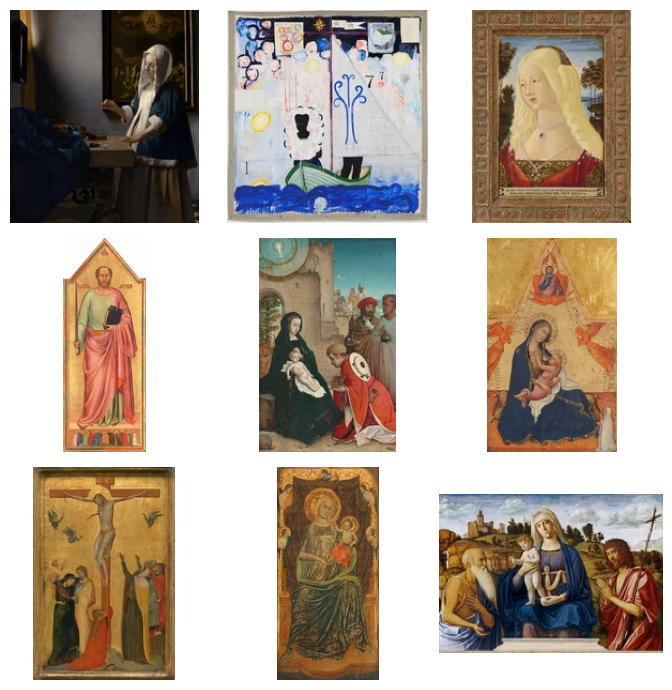

In [3]:
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
selected_images = random.sample(image_files, 9)

fig, axes = plt.subplots(3, 3, figsize=(7, 7))
for i, image_file in enumerate(selected_images):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path)
    axes[i // 3, i % 3].imshow(img)
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

### Feature Extraction

Initiate 4 different compressor for the feature extraction.
- resnet_img_general : ResnetCompressor is applied with face_crop = False
- resnet_img_face : ResnetCompressor is applied with face_crop = True
- vgg_img_general : VGGCompressor is applied with face_crop = False
- vgg_img_face: VGGCompressor is applied with face_crop = True

In [4]:
resnet = ResNetCompressor(device=device)
resnet_img_general = ImageRetrieval(resnet,folder_path,device=device)
resnet_img_face = ImageRetrieval(resnet,folder_path,face_crop = True,device=device)

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.9.0


Building Feature Vector List


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Building Feature Vector List


100%|██████████| 5/5 [00:22<00:00,  4.54s/it]


In [ ]:
vgg = VGGCompressor(device=device)
vgg_img_general = ImageRetrieval(vgg,folder_path,device=device)
vgg_img_face = ImageRetrieval(vgg,folder_path,face_crop = True,device=device)

### Evaluation

In [5]:
eval = evaluation_metrics(folder_path)
metric = 'cosine' # You can change to other distance metrics

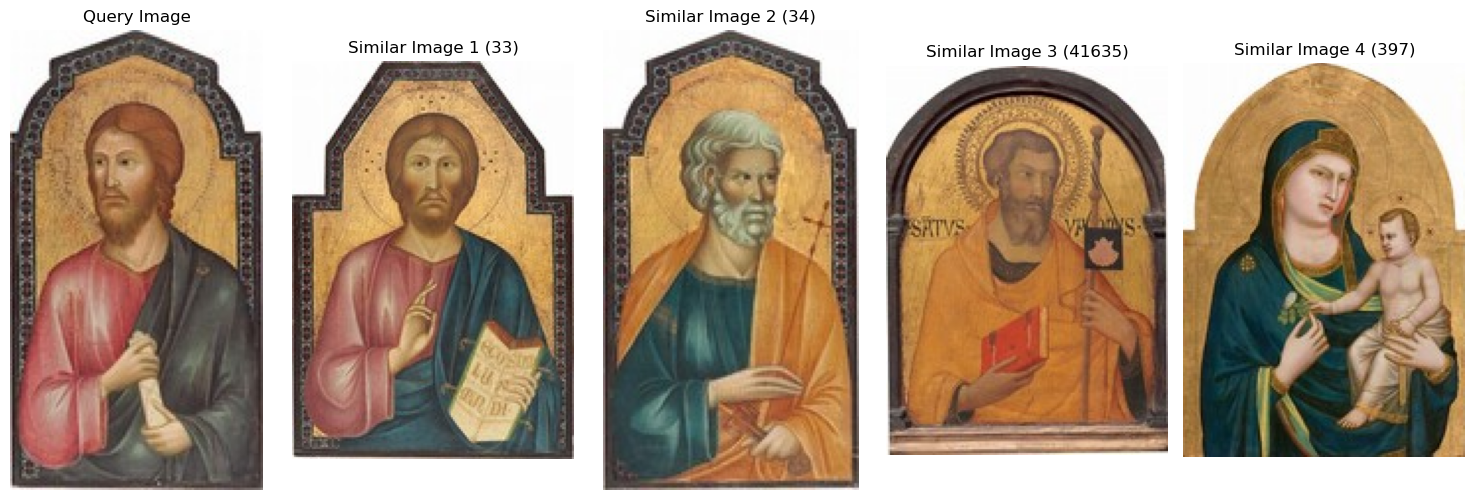

In [11]:
query_image1 = "./data/images/0.jpg"
similar_images1 = resnet_img_general.retrieve_similar_images(query_image1,metric)
eval.visualize_images(similar_images1,query_image1)

41625
150


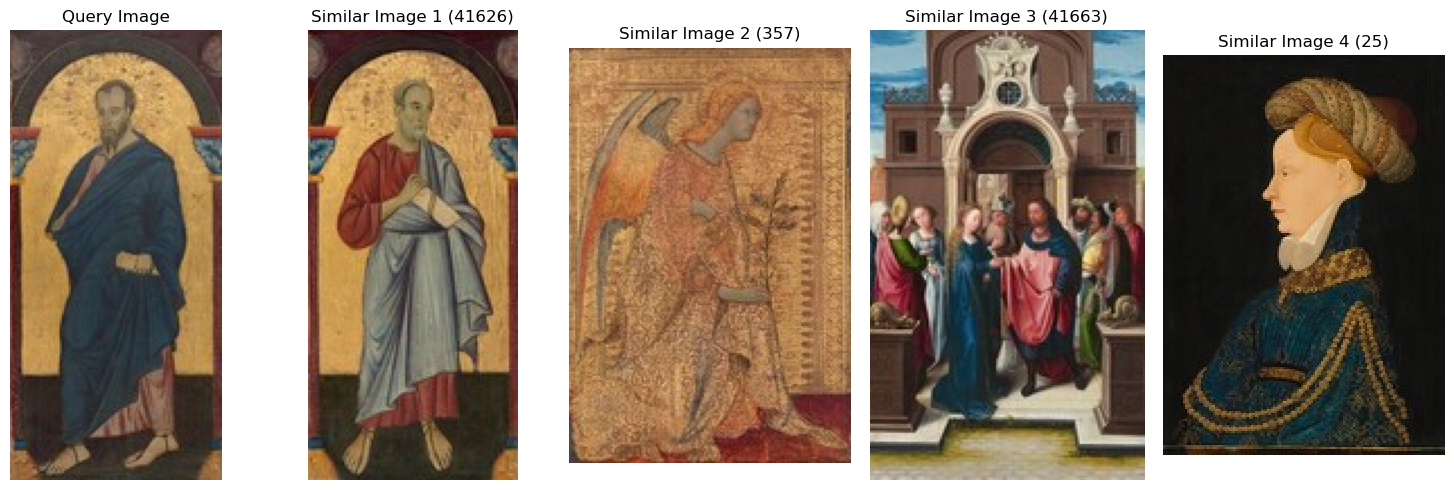

In [8]:
query_image_path = "./data/images/41625.jpg"
similar_images2 = resnet_img_general.retrieve_similar_images(query_image_path,metric)
eval.visualize_images(similar_images2,query_image_path)

45886
41


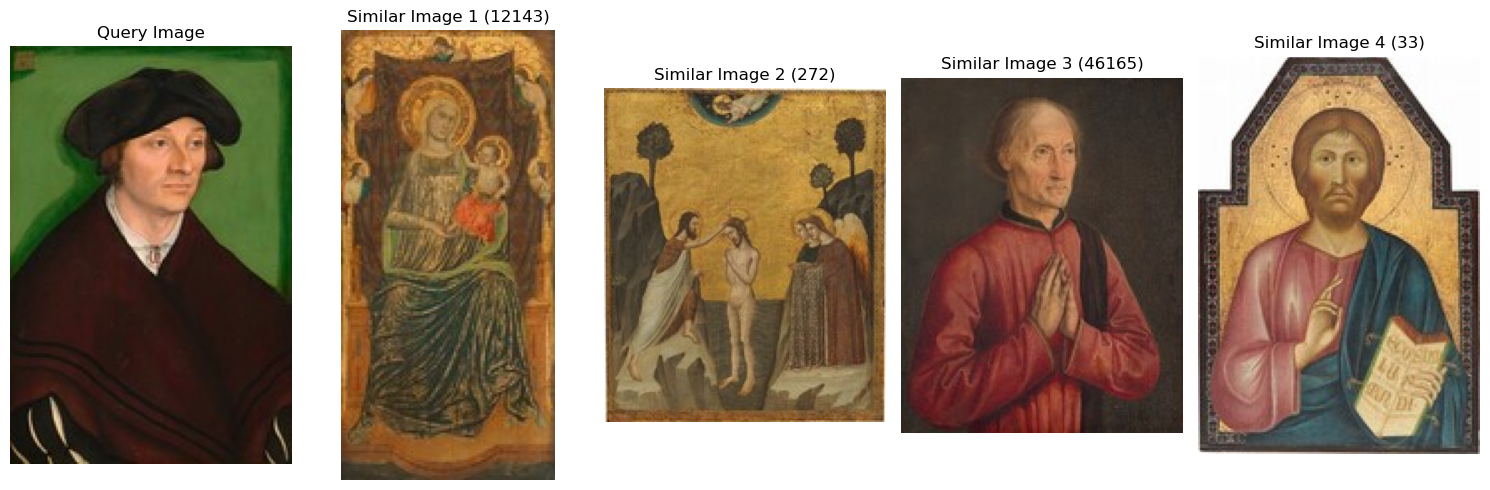

In [10]:
query_image_path = "./data/images/45886.jpg"
similar_images2 = resnet_img_general.retrieve_similar_images(query_image_path,metric)
eval.visualize_images(similar_images2,query_image_path)

In [ ]:
image_files = os.listdir(folder_path)

results = []

# Iterate over the first 30 images in the folder_path
for query_image in image_files[:30]:
    query_image_path = os.path.join(folder_path, query_image)

    # Retrieve similar images using different compressors for feature extraction
    similar_images = {
        "resnet_general": resnet_img_general.retrieve_similar_images(query_image_path, metric),
        "vgg_general": vgg_img_general.retrieve_similar_images(query_image_path, metric),
        "resnet_face": resnet_img_face.retrieve_similar_images(query_image_path, metric),
        "vgg_face": vgg_img_face.retrieve_similar_images(query_image_path, metric)
    }
    
    # Calculate evaluation metrics for each set of similar images
    for compressor, similar_images_set in similar_images.items():
        avg_ssim, avg_rmse = eval.eval_results(query_image_path, similar_images_set)
        results.append((compressor, avg_ssim, avg_rmse))
        
30_eval = pd.DataFrame(results, columns=['Compressor', 'Average SSIM Score', 'Average RMSE Score'])
print(30_eval)


In [17]:
average_scores = 30_eval.groupby('Compressor').agg({'Average SSIM Score': 'mean', 'Average RMSE Score': 'mean'})

# Display the average scores
print(average_scores)

                Average SSIM Score  Average RMSE Score
Compressor                                            
resnet_face               0.174401            0.277435
resnet_general            0.170127            0.277642
vgg_face                  0.171231            0.261491
vgg_general               0.174376            0.260189


### Result Analysis : Face Detection Status Check

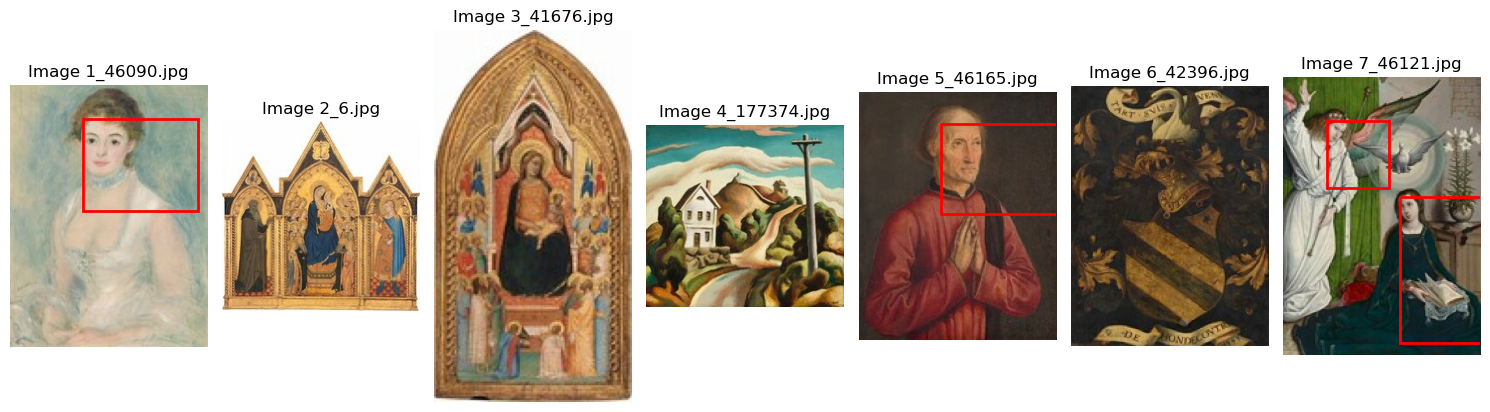

In [20]:
import matplotlib.patches as patches

def visualize_images_with_bounding_boxes(image_paths):
    mtcnn =  MTCNN(min_face_size=2,margin=10,thresholds = [0.6, 0.6, 0.6],device = device,keep_all=True,post_process=True)
    plt.figure(figsize=(15, 6))

    for i, image_path in enumerate(image_paths, start=1):
        img = Image.open(image_path)
        boxes, _ = mtcnn.detect(img)    # Detect faces in the image

        plt.subplot(1, len(image_paths), i)
        plt.imshow(img)
        plt.title(f"Image {i}_{image_path.split('/')[-1]}")

        if boxes is not None:
            for box in boxes:
                x, y, width, height = box
                rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)

        plt.axis('off')
    plt.tight_layout()
    plt.show()

image_files = os.listdir(folder_path)
sample_images = random.sample(image_files, 7)

# Create list of image paths
image_paths = [os.path.join(folder_path, image_file) for image_file in sample_images]

# Visualize the images with bounding boxes
visualize_images_with_bounding_boxes(image_paths)
